In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import random

In [ ]:
class Value:
    def __init__(self,data,_children=(), _op='',label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self._backward=lambda: None
        self.grad=0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other=other if isinstance(other,Value)else Value(other)
        out= Value(self.data+other.data,(self,other),'+')
        def backward():
            self.grad+=1*out.grad
            other.grad+=1*out.grad
        out._backward=backward
        return out
    
    def __radd__(self, other):
        return self+other
    
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out= Value(self.data*other.data,(self,other),'*')
        def backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=backward
        return out
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self,other):
        return self + (-other)

    def __pow__(self,other):
        assert isinstance(other,(int,float)),"only supporting int/float powers for now"
        out=Value(self.data**other,(self,),f'**{other}')
        def backward():
            self.grad+=other*(self.data**(other-1))*(out.grad)
        out._backward=backward 
        return out

    def __rmul__(self,other):
        return self*other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def tanh(self):
        t=(math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
        out=Value(t,(self,),'tanh')
        def backward():
            self.grad+=(1-(t**2))*out.grad
        out._backward=backward
        return out
    
    def backward(self):
        topo=[]
        visited=set()
        def buildtopo(v):
            if v not in visited:
                visited.add(v)
                for i in v._prev:
                    buildtopo(i)
                topo.append(v)
        buildtopo(self)
        self.grad=1
        for node in reversed(topo):
            node._backward()    

    def exp(self):
        x=self.data
        out=Value(math.exp(x))
        def backward():
            self.grad+=out.data*out.grad
        out._backward=backward
        return out
        

In [3]:
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
    def __call__(self,x):
       act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
       out=act.tanh()
       return out
    def parameters(self):
        return self.w +[self.b]

class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin)for _ in range(nout)]
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1])for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [4]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.26849080387823604)

In [5]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [23]:
for p in n.parameters():
    p.grad=0.0

In [24]:
ypred=[n(x) for x in xs]
loss=(sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred)))
loss

Value(data=1.362977979035215)

In [25]:
loss.backward()

In [26]:
for p in n.parameters():
    p.data+=-0.01*p.grad

In [27]:
ypred=[n(x) for x in xs]
loss=(sum((yout - ygt)for ygt,yout in zip(ys,ypred)))
loss

Value(data=-0.6721475421766757)

In [22]:
loss.backward()

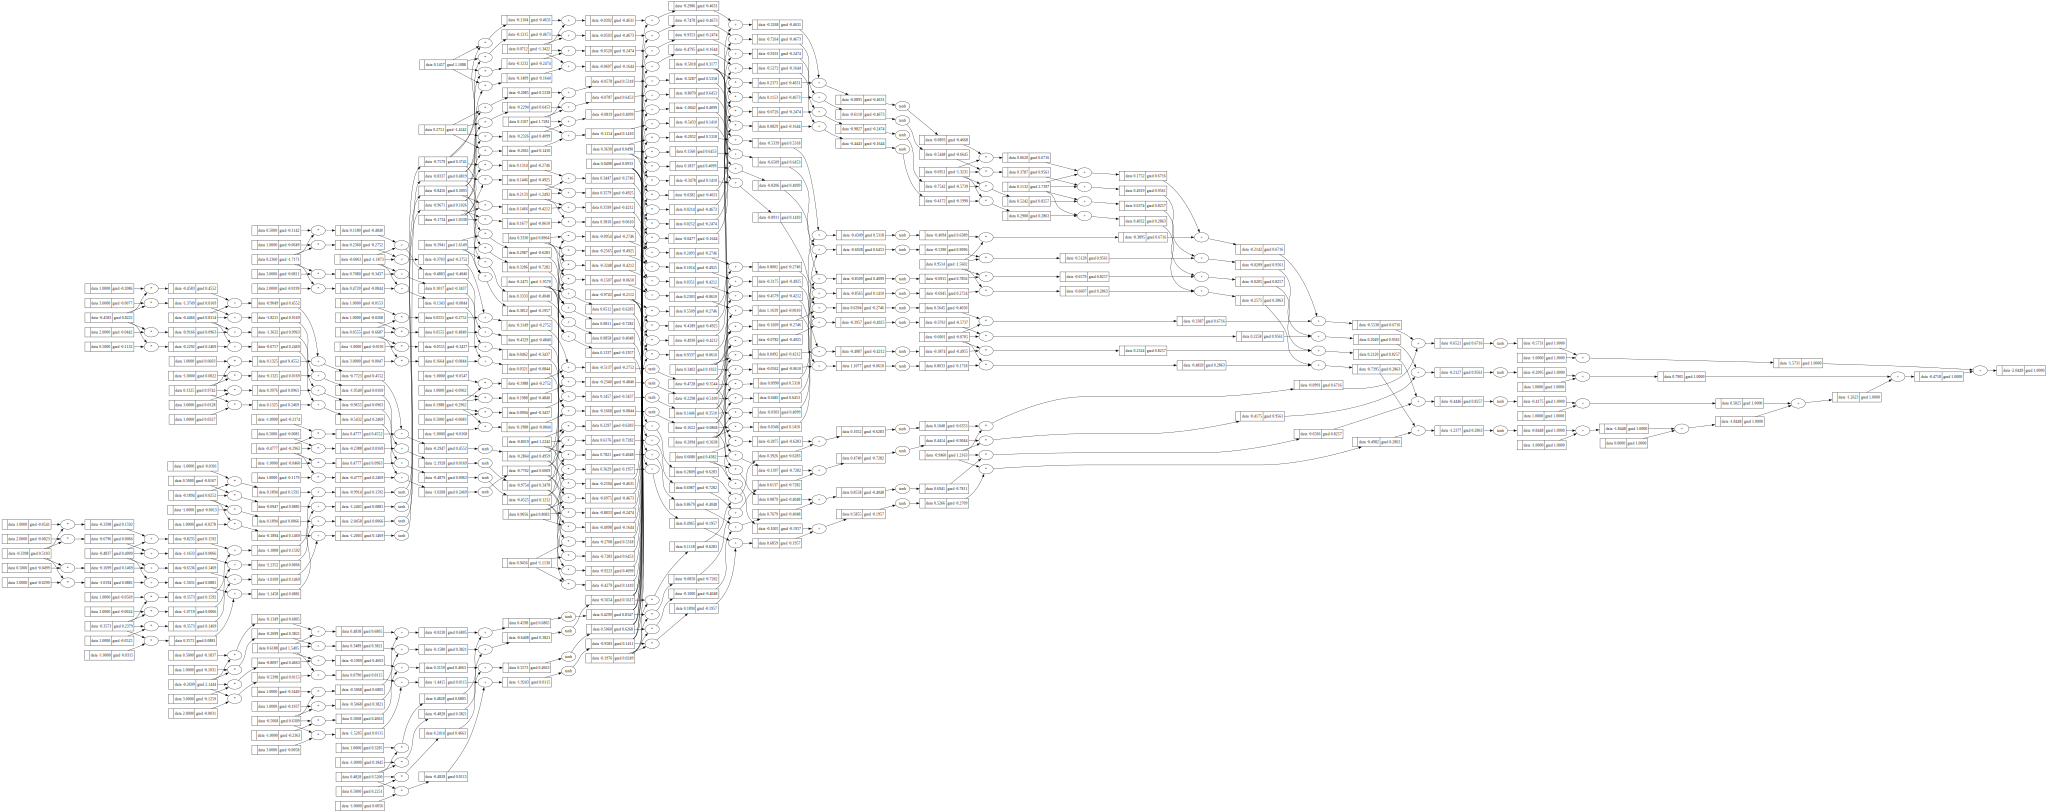

In [ ]:
draw_dot(loss)

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
from graphviz import Digraph
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot